# Estimating Precession Frequencies #

## Introduction ##

This Notebook demonstrates how to use QInfer to estimate a single precession frequency, for example in a Rabi or Ramsey experiment.

## Setup ##

First, to make sure that this example works in both Python 2 and 3, we tell Python 2 to use 3-style division and printing.

In [1]:
from __future__ import division, print_function

Next, we import QInfer itself, along with NumPy and Matplotlib.

In [2]:
import qinfer as qi
import numpy as np
import matplotlib.pyplot as plt

/home/cgranade/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We finish by configuring Matplotlib for plotting in Jupyter Notebook.

In [3]:
%matplotlib inline
try: plt.style.use('ggplot')
except: pass

## Uniform Sampling ##

In particular, we'll assume that for a frequency $\omega$, if one measures at a time $t$, then the probability of a "1" measurement is given by
\begin{equation}
    \Pr(1 | \omega, t) = \sin^2(\omega t / 2).
\end{equation}
To estimate $\omega$, we will need a set of measurements $\{(t_k, n_k)\}_{k=1}^N$, where $t_k$ is the evolution time used for the $k$th sample and where $n_k$ "1" measurements are seen. Conventionally, one might choose $t_k = k \pi / (2 \omega_\max)$, where $\omega_\max$ is the maximum frequency that one expects to observe. For each $k$, many "shots" are then collected to give a good average, such that the Fourier transform of the collected measurements clearly shows a peak at the $\omega$.

To see this, let's start by making some fake data from a precession experiment (e.g.: Rabi, Ramsey or phase estimation), then using the Fourier method.

In [4]:
true_omega = 70.3
omega_min, omega_max = [0, 99.1]
n_shots = 400

ts = np.pi * (1 + np.arange(100)) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

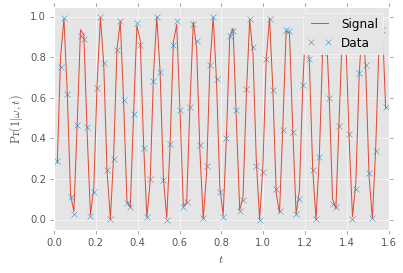

In [5]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

Now let's look at the periodogram of the data (that is, the squared modulus of the Fourier-transformed data), and note that we see the true value of $\omega$ that we used to generate the data appears as a clearly-visible peak.

In [6]:
spectrum = np.abs(np.fft.fftshift(np.fft.fft(counts - counts.mean())))**2
ft_freq = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(n=len(counts), d=ts[1] - ts[0]))

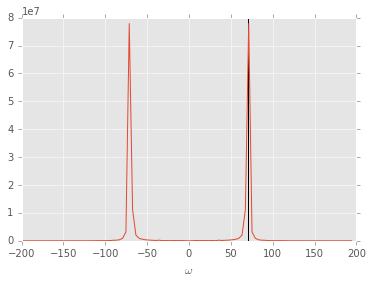

In [7]:
plt.plot(ft_freq, spectrum)
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)
plt.xlabel('$\omega$')

Though things look quite nice when zoomed out so far, if we look closer to the true value of $\omega$, we see that there's still a lot of uncertianty about the precession frequency.

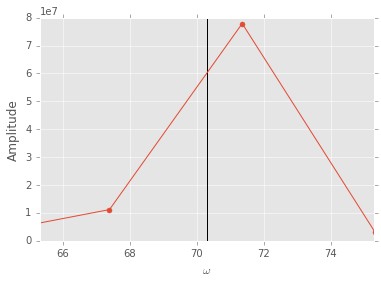

In [8]:
plt.plot(ft_freq, spectrum, '.-', markersize=10)
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)
plt.xlim(true_omega - 5, true_omega + 5)
plt.xlabel('$\omega$')
plt.ylabel('Amplitude')

We can improve on the situation dramatically by using Bayesian analysis to find the precession frequency, since in this case, we already know the phase and amplitude of the precession and that there is exactly one peak.

To do so, we first make a new array containing our data, the times we collected that data at and how many shots we used at each measurement.

In [9]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

We can then call ``qi.simple_est_prec`` with our data to find the Bayesian mean estimator (BME) for $\omega$. To see how long it takes to run, we'll surround the call with a ``qi.timing`` block; this is not necessary in practice, though.

In [10]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{}. Error: {:0.2e}. Estimated error: {:0.2e}.".format(timing, abs(mean - true_omega) / true_omega, np.sqrt(cov) / true_omega))

0.24 seconds elapsed. Error: 2.64e-05. Estimated error: 7.60e-05.


Notice that the estimation procedure also provided an error bar; this is possible because we have the entire *posterior distribution* describing our state of knowledge after the experiment.

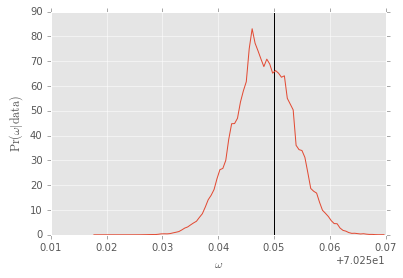

In [11]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)
plt.ylabel(r'$\Pr(\omega | \mathrm{data})$')

Indeed, the plot above only shows the uncertianty in the Bayes estimate because it is zoomed in near the peak of the posterior. If we zoom out and compare to the width of the periodogram peak, we can clearly see that the Bayes estimator does a *much* better job.

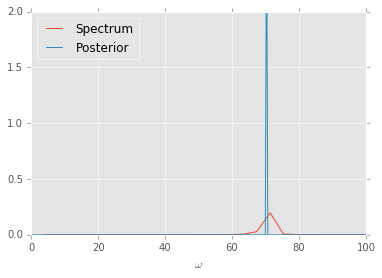

In [12]:
plt.plot(ft_freq[ft_freq > 0], spectrum[ft_freq > 0] / np.trapz(spectrum[ft_freq > 0], ft_freq[ft_freq > 0]))
xlim = plt.xlim(0, 100)
extra['updater'].plot_posterior_marginal(range_min=xlim[0], range_max=xlim[1], res=400)
plt.xlim(*xlim)
plt.legend(['Spectrum', 'Posterior'], loc='upper left')

## Exponentially-Sparse Sampling ##

Another important advantage of the Bayes estimation procedure is that we need not assume uniform sampling times. For instance, we can choose our samples to be exponentially sparse. Doing so makes it somewhat harder to visualize the data before processing, but can give us much better estimates.

In [13]:
n_shots = 400

ts = np.pi * 1.125 ** (1 + np.arange(100)) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

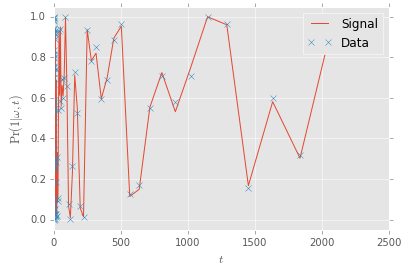

In [14]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

We can again stack the data in the same way.

In [15]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [16]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{}. Error: {:0.2e}. Estimated error: {:0.2e}.".format(timing, abs(mean - true_omega) / true_omega, np.sqrt(cov) / true_omega))

0.25 seconds elapsed. Error: 2.07e-07. Estimated error: 1.61e-07.


(0.0, 40000.0)

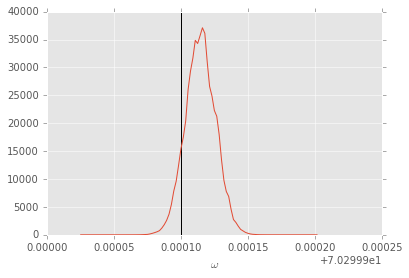

In [17]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)

## One-Bit Sampling ##

Note that we can also get very good results even when only one bit of data is used to estimate each sample.

In [18]:
true_omega = 70.3
omega_min, omega_max = [10.3, 99.1]
n_shots = 1

t_min = np.pi / 2
t_max = 100000
ts = np.logspace(np.log10(t_min), np.log10(t_max), 1000) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

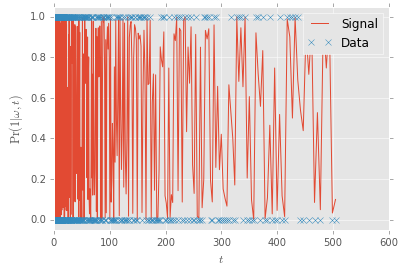

In [19]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

In [20]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [21]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{}. Error: {:0.2e}. Estimated error: {:0.2e}.".format(timing, abs(mean - true_omega) / true_omega, np.sqrt(cov) / true_omega))

2.10 seconds elapsed. Error: 2.46e-06. Estimated error: 4.35e-06.


(0.0, 1400.0)

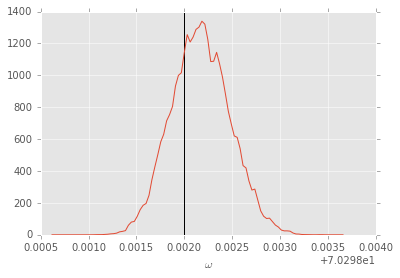

In [22]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)

## Loading Data ##

### Using Pandas DataFrames ###

If your experimental data is stored as a Pandas ``DataFrame`` (for instance, if it was loaded from an Excel file), then QInfer can use the ``DataFrame`` directly:

In [23]:
import pandas as pd

In [24]:
dataframe = pd.DataFrame(data, columns=['counts', 't', 'n_shots'])
dataframe[:10]

,counts,t,n_shots
0,0.0,0.007925,1.0
1,0.0,0.008014,1.0
2,0.0,0.008103,1.0
3,0.0,0.008193,1.0
4,0.0,0.008284,1.0
5,0.0,0.008376,1.0
6,0.0,0.008470,1.0
7,0.0,0.008564,1.0
8,0.0,0.008659,1.0
9,0.0,0.008756,1.0


In [25]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(dataframe
                                          , freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{}. Error: {:0.2e}. Estimated error: {:0.2e}.".format(timing, abs(mean - true_omega) / true_omega, np.sqrt(cov) / true_omega))

1.95 seconds elapsed. Error: 2.48e-06. Estimated error: 4.26e-06.


### Comma-Separated ###

Finally, we can also import from comma-separated files (CSV files). We'll test this out by using Python's ``StringIO`` object to simulate reading and writing to a file, so that the example is standalone.

In [26]:
try:
    # Python 2
    from cStringIO import StringIO
except ImportError:
    # Python 3
    from io import StringIO

First, we'll export the data we collected to a CSV-formatted string. In practice, the contents of this string would normally be written to a file, but we'll show the first few rows to illustrate the point.

In [27]:
csv_io = StringIO()
np.savetxt(csv_io, data, delimiter=',', fmt=['%i', '%.16e', '%i'])
csv = csv_io.getvalue()
print("\n".join(csv.split('\n')[:10]))

0,7.9253094187431723e-03,1
0,8.0135493480788175e-03,1
0,8.1027717356022474e-03,1
0,8.1929875199451881e-03,1
0,8.2842077615294524e-03,1
0,8.3764436439229366e-03,1
0,8.4697064752107271e-03,1
0,8.5640076893814636e-03,1
0,8.6593588477291445e-03,1
0,8.7557716402705370e-03,1


We can then pass a file-like object that reads from this string to QInfer, which will automatically call NumPy and load the data appropriately.

In [28]:
csv_io = StringIO(csv)
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(csv_io, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{}. Error: {:0.2e}. Estimated error: {:0.2e}.".format(timing, abs(mean - true_omega) / true_omega, np.sqrt(cov) / true_omega))

2.03 seconds elapsed. Error: 2.43e-06. Estimated error: 4.32e-06.
